In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical


In [ ]:
# Path for dataset
data_path = '/Users/reubenrosenberg/Desktop/nndl_project/data/project/'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab_Notebooks/project_data/project

Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks/project_data/project


In [4]:
import numpy as np


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


In [5]:
# Find Shape of Data

print("X_train_valid shape: ", X_train_valid.shape)
print("y_train_valid shape: ", y_train_valid.shape)
print("person_train_valid shape: ", person_train_valid.shape, '\n')
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
print("person_test shape: ", person_test.shape)


X_train_valid shape:  (2115, 22, 1000)
y_train_valid shape:  (2115,)
person_train_valid shape:  (2115, 1) 

X_test shape:  (443, 22, 1000)
y_test shape:  (443,)
person_test shape:  (443, 1)


In [6]:
y_train_valid = y_train_valid - 769
y_test = y_test - 769


In [ ]:
# Check values of y
print("y_train_valid: ", np.unique(y_train_valid))
print("y_test: ", np.unique(y_test))

# Check how many times each class occurs
unique, counts = np.unique(y_train_valid, return_counts=True)
print("y_train_valid counts: ", dict(zip(unique, counts)))
unique, counts = np.unique(y_test, return_counts=True)
print("y_test counts: ", dict(zip(unique, counts)))



y_train_valid:  [0 1 2 3]
y_test:  [0 1 2 3]
y_train_valid counts:  {0: 529, 1: 513, 2: 543, 3: 530}
y_test counts:  {0: 111, 1: 127, 2: 96, 3: 109}


In [7]:
num_classes = len(np.unique(y_train_valid))
print("num_classes: ", num_classes)


num_classes:  4


# DATA PROCESSING AND SUBSAMPLING FROM DISCUSSION

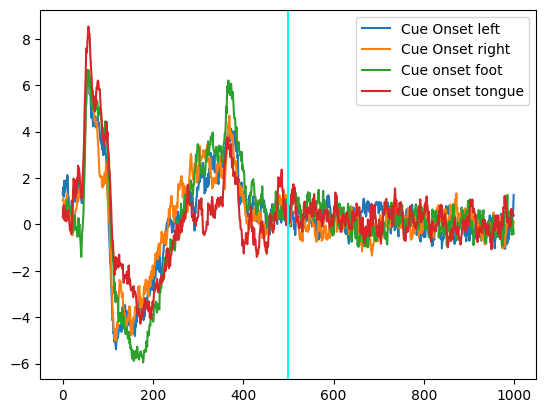

In [8]:

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [9]:
def train_data_prep(X,y,sub_sample,average,noise):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)


    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X




In [10]:

## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 256, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

# Preprocessing with above
x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_valid,y_valid = train_data_prep(x_valid,y_valid,2,2,True)
X_test_prep = test_data_prep(X_test)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of X after trimming: (1859, 22, 800)
Shape of X after maxpooling: (1859, 22, 400)
Shape of X after averaging+noise and concatenating: (3718, 22, 400)
Shape of X after subsampling and concatenating: (7436, 22, 400)
Shape of Y: (7436,)
Shape of X after trimming: (256, 22, 800)
Shape of X after maxpooling: (256, 22, 400)
Shape of X after averaging+noise and concatenating: (512, 22, 400)
Shape of X after subsampling and concatenating: (1024, 22, 400)
Shape of Y: (1024,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of training set: (7436, 22, 400)
Shape of validation set: (1024, 22, 400)
Shape of training labels: (7436,)
Shape of validation labels: (1024,)
Shape of training labels after categorical conversion: (7436, 4)
Shape of validation labels after categorical conversion: (1024, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7436, 22, 400, 1)
Shape of validation set after

# END DISCUSSION PORTION

In [11]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
from tensorflow.keras import regularizers

tf.config.run_functions_eagerly(True)




# MODEL 1
FC(40) -> LSTM(10) -> FC(40) -> LSTM (10) -> FC(32) -> FC(16) -> FC(8) -> FC(4, softmax)


In [13]:


model1 = Sequential()


# Conv Block
model1.add(Conv2D(filters=25, kernel_size=(5,5), padding='same', activation='elu', input_shape=(400,1,22)))
model1.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
model1.add(BatchNormalization())
model1.add(Dropout(0.6))

# LSTM
model1.add(Flatten()) # Adding a flattening operation to the output of CNN block
model1.add(Dense((40))) # FC layer with 100 units
model1.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
model1.add(LSTM(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False))


# FC NET
model1.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# Output layer with Softmax activation
model1.add(Dense(4, activation='softmax'))


# Compile
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 1, 25)        13775     
                                                                 
 max_pooling2d (MaxPooling2  (None, 134, 1, 25)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 134, 1, 25)        100       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 134, 1, 25)        0         
                                                                 
 flatten (Flatten)           (None, 3350)              0         
                                                                 
 dense (Dense)               (None, 40)               

In [ ]:
# Training the model
history = model1.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_valid, y_valid))


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


117/117 [==============================] - 90s 765ms/step - loss: 1.6918 - accuracy: 0.2726 - val_loss: 1.5604 - val_accuracy: 0.2949
Epoch 2/30
117/117 [==============================] - 88s 756ms/step - loss: 1.4747 - accuracy: 0.3463 - val_loss: 1.4223 - val_accuracy: 0.3203
Epoch 3/30
117/117 [==============================] - 90s 766ms/step - loss: 1.3477 - accuracy: 0.3826 - val_loss: 1.3603 - val_accuracy: 0.3545
Epoch 4/30
117/117 [==============================] - 90s 767ms/step - loss: 1.2853 - accuracy: 0.4022 - val_loss: 1.3473 - val_accuracy: 0.3525
Epoch 5/30
117/117 [==============================] - 88s 748ms/step - loss: 1.2456 - accuracy: 0.4207 - val_loss: 1.3046 - val_accuracy: 0.3828
Epoch 6/30
117/117 [==============================] - 85s 724ms/step - loss: 1.1906 - accuracy: 0.4501 - val_loss: 1.2803 - val_accuracy: 0.3809
Epoch 7/30
117/117 [==============================] - 92s 785ms/step - loss: 1.1683 - accuracy: 0.4720 - val_loss: 1.3088 - val_accuracy: 0.4

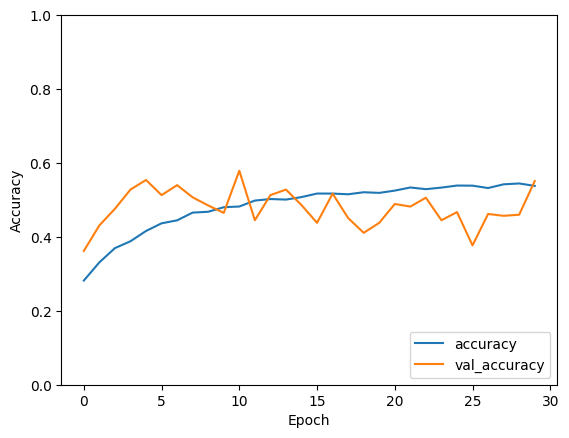

In [ ]:
# Plotting
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()



In [ ]:
# Evaluate the model on the test set
model_score = model1.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of model:',model_score[1])


Test accuracy of model: 0.4108352065086365


In [ ]:
# x_train shape
print("x_train shape: ", x_train.shape)

# Samples, timesteps, features, channels

x_train shape:  (7460, 400, 1, 22)


# MODEL 6 (Basic Conv+LSTM)

Train: 0.8240
Validation: 0.9220
Test: 0.5643340945243835

In [ ]:
# x_train shape
print("x_train shape: ", x_train.shape)

# Samples, timesteps, features, channels

x_train shape:  (7460, 400, 1, 22)


In [35]:
from tensorflow.keras.layers import LSTM, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

# Define the model
LSTM_basic = Sequential()

# Convolutional Block 1
LSTM_basic.add(Conv2D(filters=25, kernel_size=(5,5), padding='same', activation='elu', input_shape=(400,1,22)))
LSTM_basic.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
LSTM_basic.add(BatchNormalization())
LSTM_basic.add(Dropout(0.6))

# Convolutional Block 2
LSTM_basic.add(Conv2D(filters=25, kernel_size=(5,5), padding='same', activation='elu', input_shape=(400,1,22)))
LSTM_basic.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
LSTM_basic.add(BatchNormalization())
LSTM_basic.add(Dropout(0.6))


# FC + LSTM layer
LSTM_basic.add(Flatten()) # Adding a flattening operation to the output of CNN block
LSTM_basic.add(Dense((40))) # FC layer with 100 units
LSTM_basic.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
LSTM_basic.add(LSTM(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False))

# Output layer with Softmax activation
LSTM_basic.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

# Compile the LSTM_basic
LSTM_basic.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the LSTM_basic summary
LSTM_basic.summary()




Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 400, 1, 25)        13775     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 134, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_14 (Ba  (None, 134, 1, 25)        100       
 tchNormalization)                                               
                                                                 
 dropout_11 (Dropout)        (None, 134, 1, 25)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 134, 1, 25)        15650     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 1, 25)        

In [36]:
# Training the LSTM_basic
model6_history = LSTM_basic.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_valid, y_valid))


Epoch 1/30
117/117 [==============================] - 29s 201ms/step - loss: 1.3854 - accuracy: 0.2491 - val_loss: 1.3739 - val_accuracy: 0.2910
Epoch 2/30
117/117 [==============================] - 25s 211ms/step - loss: 1.3454 - accuracy: 0.3326 - val_loss: 1.2936 - val_accuracy: 0.3691
Epoch 3/30
117/117 [==============================] - 25s 217ms/step - loss: 1.2608 - accuracy: 0.4143 - val_loss: 1.1937 - val_accuracy: 0.4502
Epoch 4/30
117/117 [==============================] - 27s 229ms/step - loss: 1.1922 - accuracy: 0.4617 - val_loss: 1.1530 - val_accuracy: 0.4854
Epoch 5/30
117/117 [==============================] - 24s 208ms/step - loss: 1.1536 - accuracy: 0.4861 - val_loss: 1.1320 - val_accuracy: 0.4932
Epoch 6/30
117/117 [==============================] - 25s 210ms/step - loss: 1.1112 - accuracy: 0.5109 - val_loss: 1.1252 - val_accuracy: 0.4873
Epoch 7/30
117/117 [==============================] - 25s 212ms/step - loss: 1.0967 - accuracy: 0.5148 - val_loss: 1.0908 - val_ac

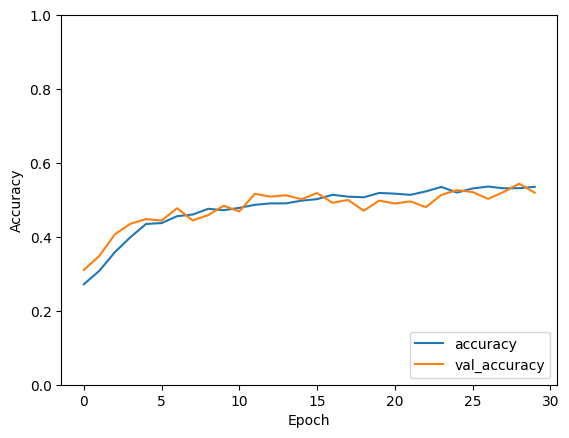

In [33]:
# Plotting
plt.plot(model6_history.history['accuracy'], label='accuracy')
plt.plot(model6_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()



In [34]:
from re import L
# Evaluate the LSTM_basic on the test set
LSTM_basic_score = LSTM_basic.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of LSTM_basic:',LSTM_basic_score[1])


Test accuracy of LSTM_basic: 0.51241534948349


# MODEL 7 (1d Convolutional)
Using the paper here:

https://iopscience.iop.org/article/10.1088/1741-2552/ac4430/meta

Which is shown to be able to achieve >99% accuracy on EEG sequence classification. We implement a similar network.

__30 Epochs__:<br>
Train: 0.55

Validation: 0.53

Test: 0.51



In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, SpatialDropout1D, AveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
DConv_model = Sequential()

# 1D Convolutional Block 1
DConv_model.add(Conv1D(filters=32, kernel_size=15, activation='relu', input_shape=(400,22), kernel_regularizer=regularizers.l2(0.01)))
DConv_model.add(AveragePooling1D(pool_size=2))
DConv_model.add(BatchNormalization())
DConv_model.add(SpatialDropout1D(rate=0.4))


# 1D Convolutional Block 2
DConv_model.add(Conv1D(filters=32, kernel_size=15, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
DConv_model.add(AveragePooling1D(pool_size=2))
DConv_model.add(BatchNormalization())
DConv_model.add(SpatialDropout1D(rate=0.2))

# 1D Convolutional Block 3
DConv_model.add(Conv1D(filters=32, kernel_size=4, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
DConv_model.add(AveragePooling1D(pool_size=2))
DConv_model.add(BatchNormalization())
DConv_model.add(SpatialDropout1D(rate=0.2))

# Average Pooling 1D
DConv_model.add(AveragePooling1D(pool_size=2))

# 1D Convolutional Block 4
DConv_model.add(Conv1D(filters=32, kernel_size=4, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
DConv_model.add(SpatialDropout1D(rate=0.2))

# Flatten the output
DConv_model.add(Flatten())

# Fully Connected (FC) layers
DConv_model.add(Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
DConv_model.add(Dropout(rate=0.5))
DConv_model.add(Dense(units=32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
DConv_model.add(Dropout(rate=0.5))
DConv_model.add(Dense(units=4, activation='softmax'))

# Compile the 1DConv_model
DConv_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print 1DConv_model summary
DConv_model.summary()




Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 386, 32)           10592     
                                                                 
 average_pooling1d_10 (Aver  (None, 193, 32)           0         
 agePooling1D)                                                   
                                                                 
 batch_normalization_8 (Bat  (None, 193, 32)           128       
 chNormalization)                                                
                                                                 
 spatial_dropout1d_10 (Spat  (None, 193, 32)           0         
 ialDropout1D)                                                   
                                                                 
 conv1d_14 (Conv1D)          (None, 179, 32)           15392     
                                                      

In [20]:
x_train_1d = x_train[:, :, 0, :]
print(x_train_1d.shape)

x_valid_1d = x_valid[:, :, 0, :]
print(x_valid_1d.shape)

x_test_1d = x_test[:, :, 0, :]
print(x_test_1d.shape)

(7436, 400, 22)
(1024, 400, 22)
(443, 400, 22)


In [26]:
# Training the DConv model
DConv_model_history = DConv_model.fit(x_train_1d, y_train, epochs=60, batch_size=64, validation_data=(x_valid_1d, y_valid))


Epoch 1/60
117/117 [==============================] - 17s 121ms/step - loss: 5.0772 - accuracy: 0.2531 - val_loss: 3.8280 - val_accuracy: 0.2139
Epoch 2/60
117/117 [==============================] - 13s 114ms/step - loss: 3.0157 - accuracy: 0.2786 - val_loss: 2.3750 - val_accuracy: 0.2754
Epoch 3/60
117/117 [==============================] - 14s 121ms/step - loss: 1.9949 - accuracy: 0.3568 - val_loss: 1.7511 - val_accuracy: 0.3867
Epoch 4/60
117/117 [==============================] - 14s 118ms/step - loss: 1.5756 - accuracy: 0.4162 - val_loss: 1.4710 - val_accuracy: 0.4297
Epoch 5/60
117/117 [==============================] - 14s 119ms/step - loss: 1.4267 - accuracy: 0.4336 - val_loss: 1.3532 - val_accuracy: 0.4502
Epoch 6/60
117/117 [==============================] - 14s 119ms/step - loss: 1.3679 - accuracy: 0.4402 - val_loss: 1.3256 - val_accuracy: 0.4297
Epoch 7/60
117/117 [==============================] - 14s 122ms/step - loss: 1.3486 - accuracy: 0.4415 - val_loss: 1.3118 - val_ac

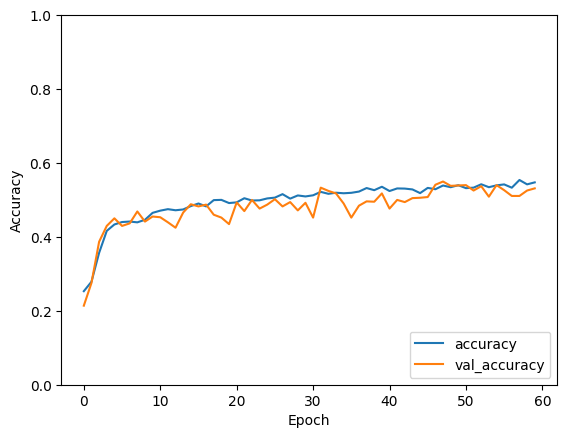

In [27]:
# Plotting
plt.plot(DConv_model_history.history['accuracy'], label='accuracy')
plt.plot(DConv_model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()



In [28]:
from re import L
# Evaluate the DConv_model on the test set
DConv_model_score = DConv_model.evaluate(x_test_1d, y_test, verbose=0)
print('Test accuracy of DConv_model:',DConv_model_score[1])


Test accuracy of DConv_model: 0.5101580023765564


# MODEL 8 (Conv + LSTM)

From this paper https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9055952

Train: 0.9984

Validation: 0.9940

Test: 0.467269

need to add more regularization

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, SpatialDropout1D, AveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers


conv_LSTM_model = Sequential()

# 1D Convolutional Block 1
conv_LSTM_model.add(Conv1D(filters=32, kernel_size=15, activation='relu', input_shape=(400,22), kernel_regularizer=regularizers.l2(0.01)))
conv_LSTM_model.add(BatchNormalization())
conv_LSTM_model.add(AveragePooling1D(pool_size=2))
conv_LSTM_model.add(Dropout(0.2))  # Add dropout layer

# 1D Convolutional Block 2
conv_LSTM_model.add(Conv1D(filters=32, kernel_size=15, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
conv_LSTM_model.add(BatchNormalization())
conv_LSTM_model.add(AveragePooling1D(pool_size=2))
conv_LSTM_model.add(Dropout(0.2))  # Add dropout layer

# Flatten the output
conv_LSTM_model.add(Flatten())
conv_LSTM_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
conv_LSTM_model.add(Reshape((256,1)))
conv_LSTM_model.add(LSTM(8))

# Softmax classifier
conv_LSTM_model.add(Dense(4, activation='softmax'))

# Compile the model
conv_LSTM_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
conv_LSTM_model.summary()


NameError: name 'regularizers' is not defined

In [38]:
x_train_1d = x_train[:, :, 0, :]
print(x_train_1d.shape)

x_valid_1d = x_valid[:, :, 0, :]
print(x_valid_1d.shape)

x_test_1d = x_test[:, :, 0, :]
print(x_test_1d.shape)

(7436, 400, 22)
(1024, 400, 22)
(443, 400, 22)


In [39]:
# Training the conv_LSTM_model model
conv_LSTM_model_history = conv_LSTM_model.fit(x_train_1d, y_train, epochs=30, batch_size=64, validation_data=(x_valid_1d, y_valid))


Epoch 1/30
117/117 [==============================] - 33s 237ms/step - loss: 1.3214 - accuracy: 0.4051 - val_loss: 1.2826 - val_accuracy: 0.4209
Epoch 2/30
117/117 [==============================] - 26s 220ms/step - loss: 0.9864 - accuracy: 0.6179 - val_loss: 1.2818 - val_accuracy: 0.4639
Epoch 3/30
117/117 [==============================] - 26s 223ms/step - loss: 0.6772 - accuracy: 0.7246 - val_loss: 1.3506 - val_accuracy: 0.4551
Epoch 4/30
117/117 [==============================] - 26s 219ms/step - loss: 0.4756 - accuracy: 0.8343 - val_loss: 1.4441 - val_accuracy: 0.4775
Epoch 5/30
117/117 [==============================] - 26s 220ms/step - loss: 0.3691 - accuracy: 0.8939 - val_loss: 1.4382 - val_accuracy: 0.4893
Epoch 6/30
117/117 [==============================] - 26s 223ms/step - loss: 0.2805 - accuracy: 0.9258 - val_loss: 1.5749 - val_accuracy: 0.5059
Epoch 7/30
117/117 [==============================] - 41s 352ms/step - loss: 0.2484 - accuracy: 0.9363 - val_loss: 1.7213 - val_ac

KeyboardInterrupt: 

In [40]:
# Plotting
plt.plot(conv_LSTM_model_history.history['accuracy'], label='accuracy')
plt.plot(conv_LSTM_model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()



NameError: name 'conv_LSTM_model_history' is not defined

In [41]:
from re import L
# Evaluate the conv_LSTM_model on the test set
conv_LSTM_model_score = conv_LSTM_model.evaluate(x_test_1d, y_test, verbose=0)
print('Test accuracy of conv_LSTM_model:',conv_LSTM_model_score[1])


Test accuracy of conv_LSTM_model: 0.51241534948349


# MODEL 9 (Vanilla RNN)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Create the model
model = Sequential()

# Add the RNN layer
model.add(SimpleRNN(units=64, input_shape=(timesteps, features)))

# Add a dense layer for classification
model.add(Dense(units=num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 386, 32)           10592     
                                                                 
 batch_normalization_13 (Ba  (None, 386, 32)           128       
 tchNormalization)                                               
                                                                 
 average_pooling1d_7 (Avera  (None, 193, 32)           0         
 gePooling1D)                                                    
                                                                 
 conv1d_17 (Conv1D)          (None, 179, 32)           15392     
                                                                 
 batch_normalization_14 (Ba  (None, 179, 32)           128       
 tchNormalization)                                               
                                                     

In [ ]:
x_train_1d = x_train[:, :, 0, :]
print(x_train_1d.shape)

x_valid_1d = x_valid[:, :, 0, :]
print(x_valid_1d.shape)

x_test_1d = x_test[:, :, 0, :]
print(x_test_1d.shape)

(7460, 400, 22)
(1000, 400, 22)
(443, 400, 22)


In [ ]:
# Training the conv_LSTM_model model
conv_LSTM_model_history = conv_LSTM_model.fit(x_train_1d, y_train, epochs=30, batch_size=64, validation_data=(x_valid_1d, y_valid))


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/30
117/117 [==============================] - 12s 104ms/step - loss: 1.3041 - accuracy: 0.3941 - val_loss: 1.2438 - val_accuracy: 0.4660
Epoch 2/30
117/117 [==============================] - 11s 94ms/step - loss: 1.0328 - accuracy: 0.5658 - val_loss: 1.0265 - val_accuracy: 0.5570
Epoch 3/30
117/117 [==============================] - 11s 92ms/step - loss: 0.7890 - accuracy: 0.6507 - val_loss: 0.8343 - val_accuracy: 0.6310
Epoch 4/30
117/117 [==============================] - 11s 96ms/step - loss: 0.6118 - accuracy: 0.7185 - val_loss: 0.6007 - val_accuracy: 0.7280
Epoch 5/30
117/117 [==============================] - 11s 97ms/step - loss: 0.4857 - accuracy: 0.7842 - val_loss: 0.5014 - val_accuracy: 0.7990
Epoch 6/30
117/117 [==============================] - 13s 107ms/step - loss: 0.4306 - accuracy: 0.8209 - val_loss: 0.4843 - val_accuracy: 0.8020
Epoch 7/30
117/117 [==============================] - 11s 98ms/step - loss: 0.3789 - accuracy: 0.8610 - val_loss: 0.4304 - val_accurac

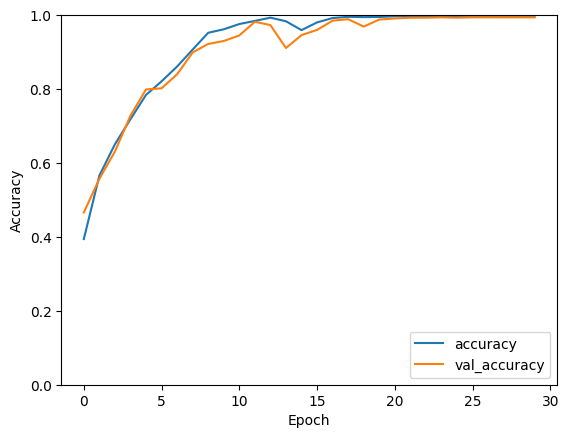

In [ ]:
# Plotting
plt.plot(conv_LSTM_model_history.history['accuracy'], label='accuracy')
plt.plot(conv_LSTM_model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()



In [ ]:
from re import L
# Evaluate the conv_LSTM_model on the test set
conv_LSTM_model_score = conv_LSTM_model.evaluate(x_test_1d, y_test, verbose=0)
print('Test accuracy of conv_LSTM_model:',conv_LSTM_model_score[1])


Test accuracy of conv_LSTM_model: 0.46726861596107483
